In [1]:
# ! pip install pandas
# ! pip install seaborn
# ! pip install xgboost
# ! pip install scikit-optimize
# ! pip install openpyxl

In [2]:
import pandas as pd
from lib.lib import *
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_excel(f'data/CNT_Growth_Rate_Simulation_with_noise.xlsx')
data.head()

,Experiment Number,"Temperature (Tp, °C)","Time (t, s)","Catalyst Thickness (d, nm)",CNT-G (micrometers/s)
0,1,600,0,0.6,0.000000
1,1,600,1,0.6,0.000005
2,1,600,2,0.6,0.000009
3,1,600,3,0.6,0.000013
4,1,600,4,0.6,0.000014


In [4]:
data.shape

(163336, 5)

In [5]:
data.describe()

,Experiment Number,"Temperature (Tp, °C)","Time (t, s)","Catalyst Thickness (d, nm)",CNT-G (micrometers/s)
count,163336.000000,163336.000000,163336.000000,163336.000000,163336.000000
mean,68.500000,800.000000,600.000000,1.300000,0.227528
std,39.258877,122.474862,346.699778,0.458259,0.348810
min,1.000000,600.000000,0.000000,0.600000,0.000000
25%,34.750000,700.000000,300.000000,0.950000,0.006312
50%,68.500000,800.000000,600.000000,1.300000,0.067233
75%,102.250000,900.000000,900.000000,1.650000,0.272437
max,136.000000,1000.000000,1200.000000,2.000000,2.251545


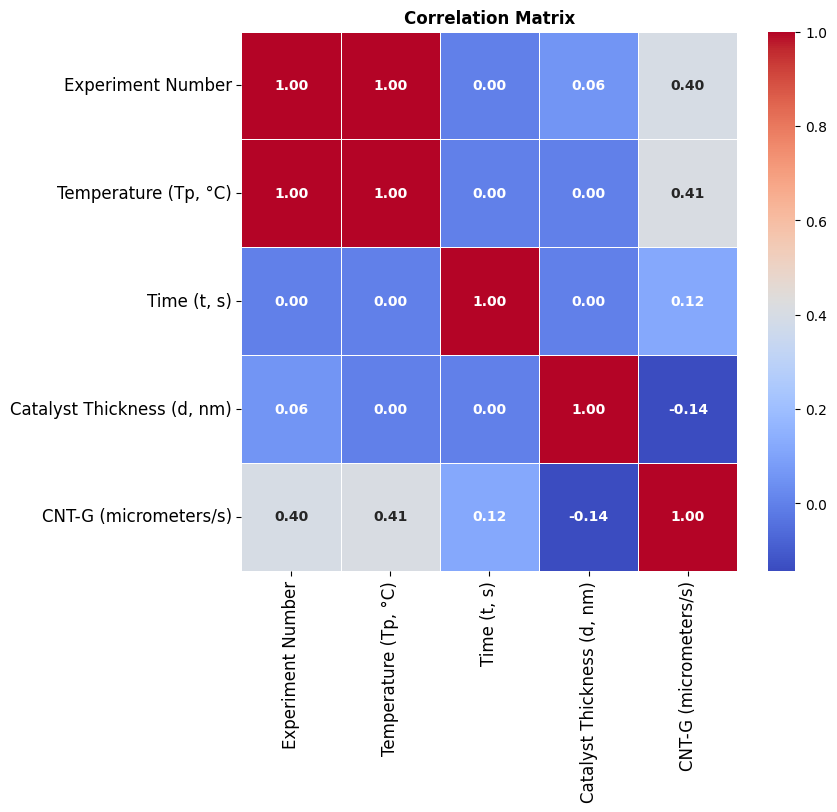

In [6]:
get_data_correlation(data)

In [7]:
target = ['CNT-G (micrometers/s)']
features = ['Temperature (Tp, °C)', 'Time (t, s)', 'Catalyst Thickness (d, nm)']

In [8]:
Y = data[target]
X = data.drop(target, axis=1)

In [9]:
from sklearn.ensemble import IsolationForest

# Combine X and Y for anomaly detection
data_combined = pd.concat([X, Y], axis=1)

# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.1, random_state=42)

# Fit the model
iso_forest.fit(data_combined)

# Predict anomalies
anomalies = iso_forest.predict(data_combined)

# Filter out the anomalies
filtered_data = data_combined[anomalies == 1]

# Separate the filtered X and Y
X_filtered = filtered_data[features]
Y_filtered = filtered_data[target]


In [10]:
X_filtered.shape, Y_filtered.shape, data.shape

((147002, 3), (147002, 1), (163336, 5))

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X_filtered, Y_filtered, test_size=0.2, random_state=42, shuffle=True)

# Display the shapes of the resulting datasets
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(117601, 3) (29401, 3) (117601, 1) (29401, 1)


In [12]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

R^2 CNT-G: 0.992669224662804
MAE CNT-G: 0.010393859253060234
MSE CNT-G: 0.0005680350633739254
RMSE CNT-G: 0.02383348617751766


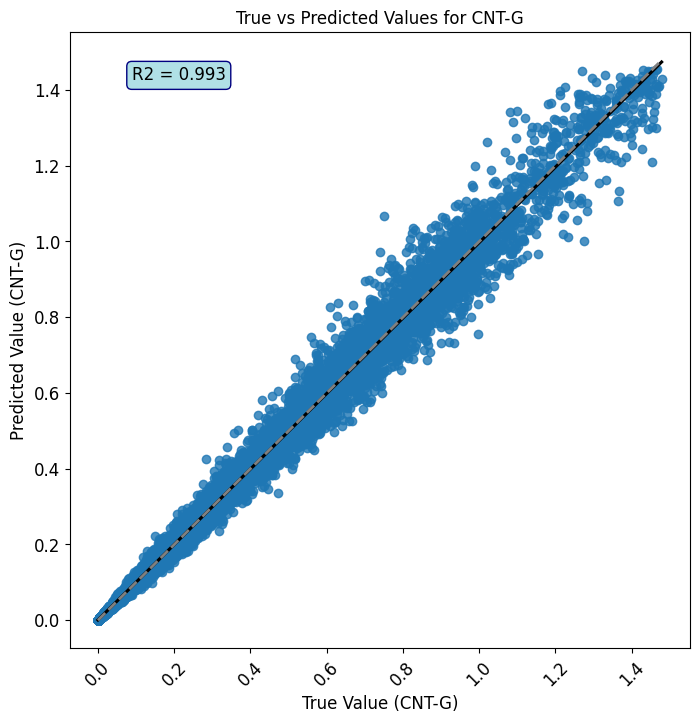

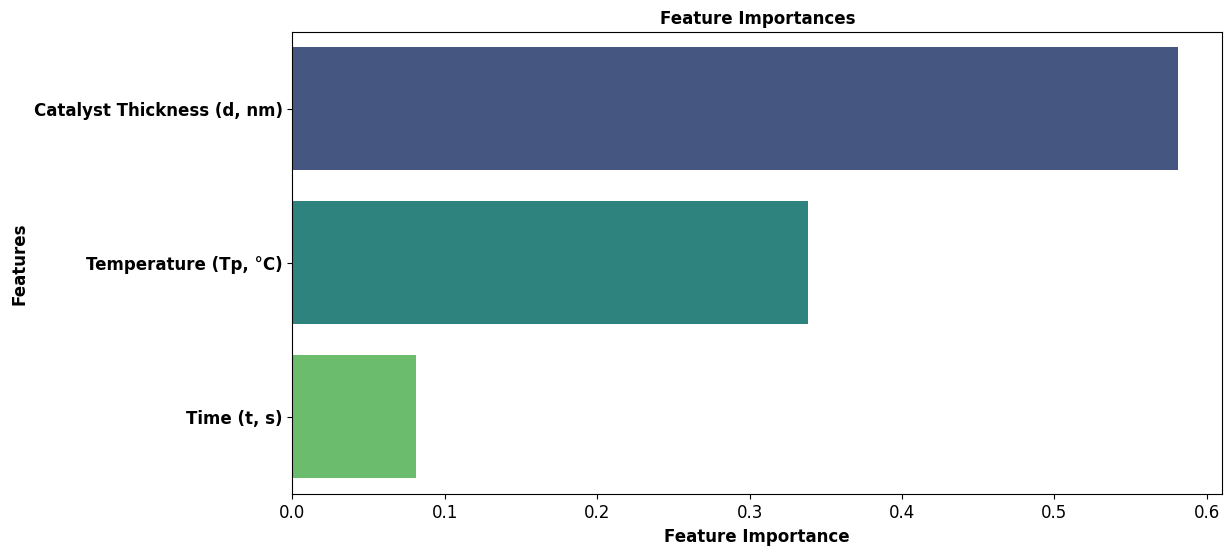

In [13]:
model_prediction = rf_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(rf_model,features)

In [15]:
original_data = pd.read_csv('data/CNTGrowthData.csv')
original_data.head()

,growth_rate,Conductance,Time_s,Temperature ( in C ),Catalyst Layer Thickness ( in nm ),Run_ID,Status_of_Exp,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,4.520099,0.000169,132,625,2,1,Success,NaN,NaN,NaN,NaN,NaN
1,4.490667,0.000172,134,625,2,1,Success,NaN,NaN,NaN,NaN,NaN
2,4.503352,0.000174,136,625,2,1,Success,NaN,NaN,NaN,NaN,NaN
3,4.573735,0.000177,138,625,2,1,Success,NaN,NaN,NaN,NaN,NaN
4,6.329410,0.000186,140,625,2,1,Success,NaN,NaN,NaN,NaN,NaN


In [16]:
original_data.rename(columns={
    'Run_ID': 'Experiment Number',
    'Temperature ( in C )': 'Temperature (Tp, °C)',
    'Catalyst Layer Thickness ( in nm )': 'Catalyst Thickness (d, nm)',
    'Time_s': 'Time (t, s)',
    'growth_rate': 'CNT-G (micrometers/s)'
}, inplace=True)
original_data = original_data[list(data.columns)]
original_data["Experiment Number"] = original_data["Experiment Number"] + max(data["Experiment Number"])
original_data.head()

,Experiment Number,"Temperature (Tp, °C)","Time (t, s)","Catalyst Thickness (d, nm)",CNT-G (micrometers/s)
0,137,625,132,2,4.520099
1,137,625,134,2,4.490667
2,137,625,136,2,4.503352
3,137,625,138,2,4.573735
4,137,625,140,2,6.329410


In [17]:
data_combined = pd.concat([data, original_data], axis=0)
data_combined.shape

(167802, 5)

In [18]:
data_combined["Experiment Number"].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139])

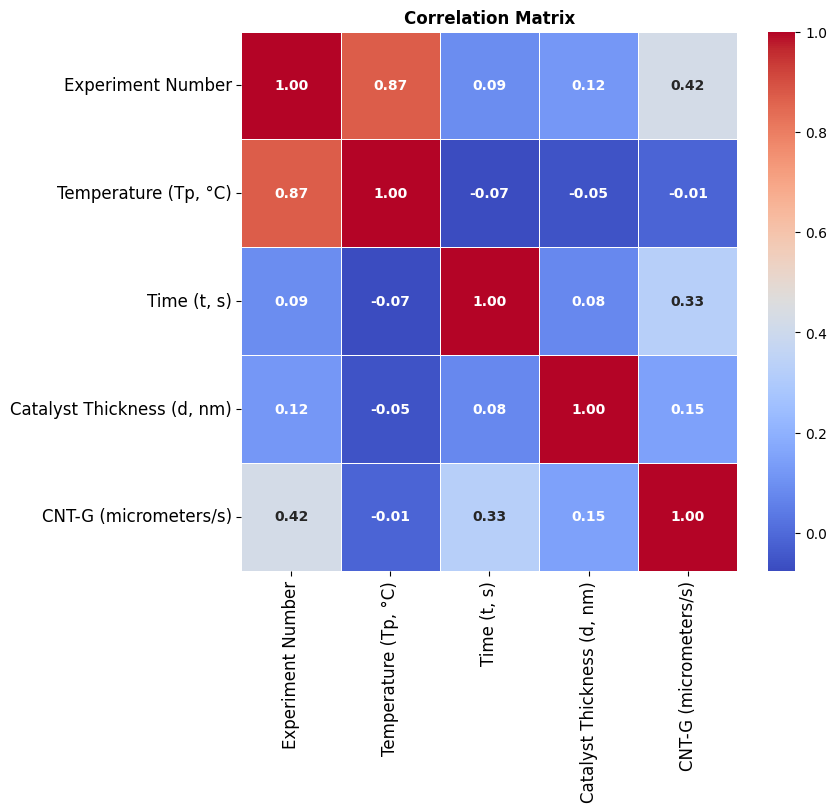

In [19]:
get_data_correlation(data_combined)

In [20]:
# Define the experiment numbers to be used as the test set
test_experiment_numbers = [3, 19, 37, 100, 138]

# Separate the test set
test_set = data_combined[data_combined['Experiment Number'].isin(test_experiment_numbers)]

# Separate the training set
training_set = data_combined[~data_combined['Experiment Number'].isin(test_experiment_numbers)]

# Display the shapes of the resulting datasets
print("Training set shape:", training_set.shape)
print("Test set shape:", test_set.shape)

Training set shape: (161514, 5)
Test set shape: (6288, 5)


In [21]:
Y_train = training_set[target]
X_train = training_set.drop(target, axis=1)
X_train = X_train.drop("Experiment Number", axis=1)

Y_test = test_set[target]
X_test = test_set.drop(target, axis=1)
X_test = X_test.drop("Experiment Number", axis=1)

In [22]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (161514, 3)
Y_train shape: (161514, 1)
X_test shape: (6288, 3)
Y_test shape: (6288, 1)


In [23]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

R^2 CNT-G: 0.8249299405858671
MAE CNT-G: 0.28973878906832
MSE CNT-G: 0.5191855534640903
RMSE CNT-G: 0.7205453167317725


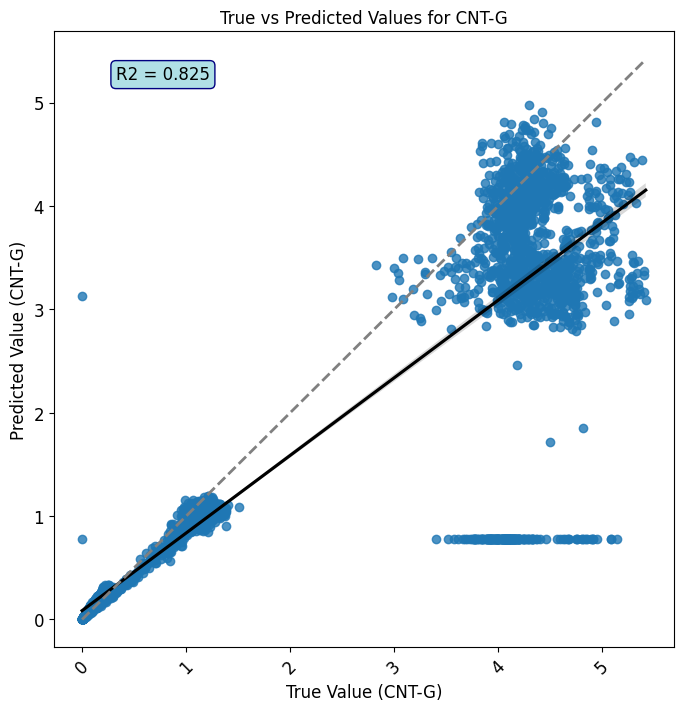

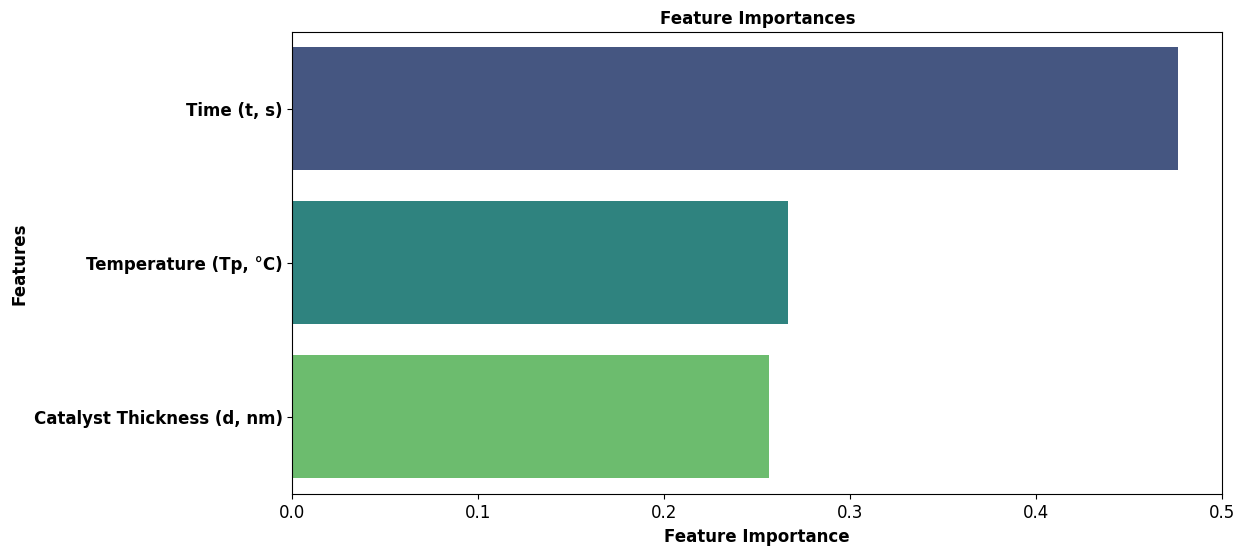

In [24]:
model_prediction = rf_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(rf_model,features)

In [25]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100, random_state=42)
xgb_model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

R^2 CNT-G: 0.906597375869751
MAE CNT-G: 0.21416351719956728
MSE CNT-G: 0.2769936299172728
RMSE CNT-G: 0.5263018429734716


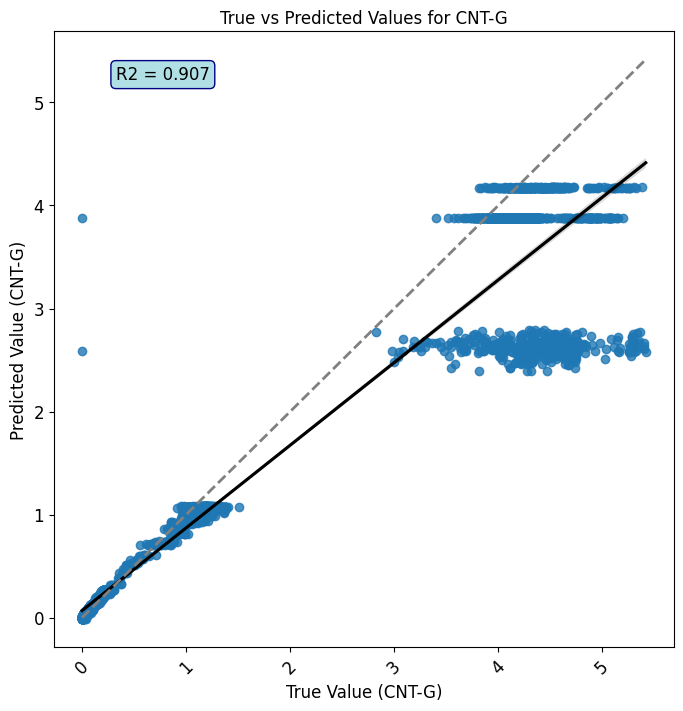

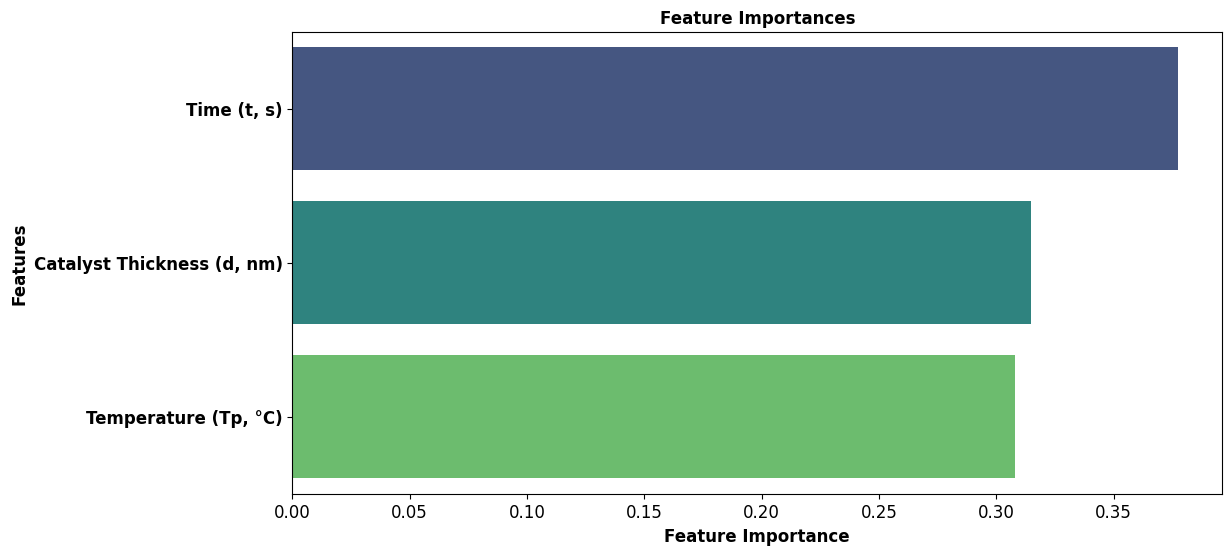

In [26]:
model_prediction = xgb_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(xgb_model,features)

In [27]:
model_parm = {
    'solver': 'lbfgs',
    'hidden_layer_sizes': (64,32),
    'alpha': 0.1,
    'activation': 'relu'
}
ann_model = MLPRegressor(max_iter=1000, random_state=42, **model_parm)
ann_model.fit(X_train, Y_train)

MLPRegressor(alpha=0.1, hidden_layer_sizes=(64, 32), max_iter=1000,
             random_state=42, solver='lbfgs')

R^2 CNT-G: 0.49053954163861324
MAE CNT-G: 0.574248304429065
MSE CNT-G: 1.5108494903559335
RMSE CNT-G: 1.2291661768678528


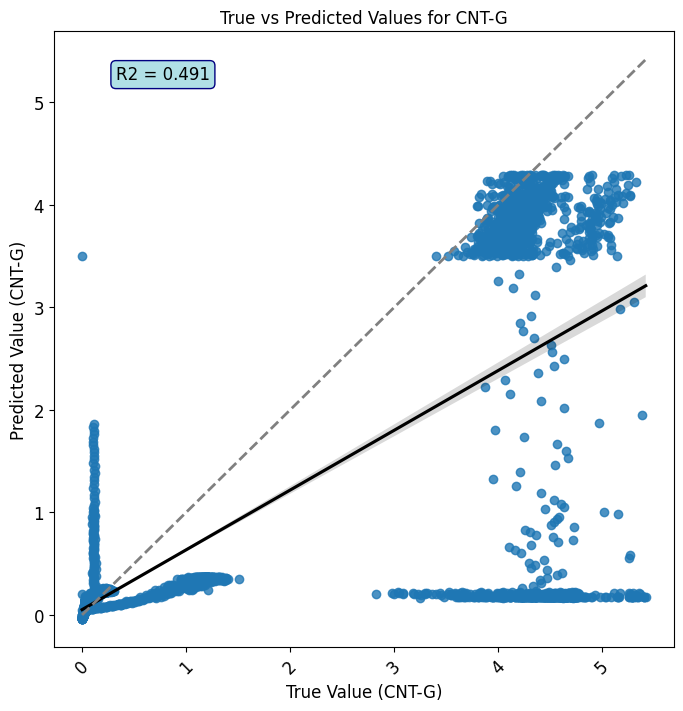

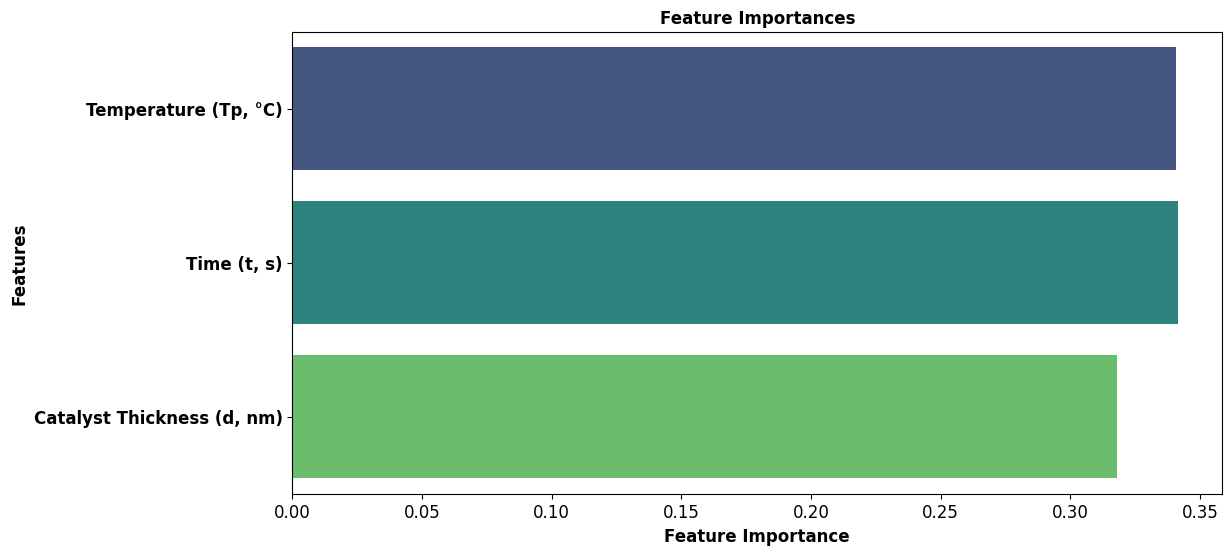

In [28]:
model_prediction = ann_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(ann_model,features, model_name="ann")

In [14]:
temperature_range = [600, 625, 650,675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
thickness_range = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]

In [14]:
min_temp = min(temperature_range)
max_temp = max(temperature_range)
temp = [int(temp) for temp in np.linspace(min_temp, max_temp, 100) if temp not in temperature_range]

min_thikness = min(thickness_range)
max_thikness = max(thickness_range)
thikness = [round(thikness,3) for thikness in np.linspace(min_thikness, max_thikness, 100) if temp not in thickness_range]
thikness[0] = 0.61

print(temp)
print(thikness)

[604, 608, 612, 616, 620, 624, 628, 632, 636, 640, 644, 648, 652, 656, 660, 664, 668, 672, 676, 680, 684, 688, 692, 696, 701, 705, 709, 713, 717, 721, 725, 729, 733, 737, 741, 745, 749, 753, 757, 761, 765, 769, 773, 777, 781, 785, 789, 793, 797, 802, 806, 810, 814, 818, 822, 826, 830, 834, 838, 842, 846, 850, 854, 858, 862, 866, 870, 874, 878, 882, 886, 890, 894, 898, 903, 907, 911, 915, 919, 923, 927, 931, 935, 939, 943, 947, 951, 955, 959, 963, 967, 971, 975, 979, 983, 987, 991, 995]
[0.61, 0.614, 0.628, 0.642, 0.657, 0.671, 0.685, 0.699, 0.713, 0.727, 0.741, 0.756, 0.77, 0.784, 0.798, 0.812, 0.826, 0.84, 0.855, 0.869, 0.883, 0.897, 0.911, 0.925, 0.939, 0.954, 0.968, 0.982, 0.996, 1.01, 1.024, 1.038, 1.053, 1.067, 1.081, 1.095, 1.109, 1.123, 1.137, 1.152, 1.166, 1.18, 1.194, 1.208, 1.222, 1.236, 1.251, 1.265, 1.279, 1.293, 1.307, 1.321, 1.335, 1.349, 1.364, 1.378, 1.392, 1.406, 1.42, 1.434, 1.448, 1.463, 1.477, 1.491, 1.505, 1.519, 1.533, 1.547, 1.562, 1.576, 1.59, 1.604, 1.618, 1.63

In [15]:
data.columns

Index(['Experiment Number', 'Temperature (Tp, °C)', 'Time (t, s)',
       'Catalyst Thickness (d, nm)', 'CNT-G (micrometers/s)'],
      dtype='object')

In [18]:
# Create a dataframe with the specified columns
temperature = temp[0]
catalyst_thickness = thikness[0]
time_values = np.arange(0, 1201, 1)  # Time values from 0 to 1200

# Create the dataframe
df_new = pd.DataFrame({
    'Temperature (Tp, °C)': [temperature] * len(time_values),
    'Time (t, s)': time_values,
    'Catalyst Thickness (d, nm)': [catalyst_thickness] * len(time_values)
})
df_new['CNT-G (micrometers/s)'] = rf_model.predict(df_new)
df_new['Experiment Number'] = 1
df_new = df_new[data.columns]
df_new.head()

,Experiment Number,"Temperature (Tp, °C)","Time (t, s)","Catalyst Thickness (d, nm)",CNT-G (micrometers/s)
0,1,604,0,0.61,0.000156
1,1,604,1,0.61,0.000156
2,1,604,2,0.61,0.000159
3,1,604,3,0.61,0.000167
4,1,604,4,0.61,0.000171


Input:
1. Time of experiment 20 minutes
2. temperature
3. Catlyst thickness
4. catalyst type -- Fe, Aluminium Oxide -- fixed


Output:
1. lowest growth rate
2. highest growth rate
3. avergae growth rate
4. highest height in 20 minute.
5. height in 10 minutes.
5. time of height saturation?? or time when 90% growth height was achieved




In [ ]:
import pandas as pd
from docx import Document
from statistics import mean
from datetime import datetime
from docx.shared import Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH

df = df_new

def analyze_data(df):
    # Growth rate analysis
    growth_rates = df['CNT-G (micrometers/s)']
    total_growth = growth_rates.sum()
    target_growth = total_growth * 0.9
    df['Cumulative Growth'] = df['CNT-G (micrometers/s)'].cumsum()
    time_of_90_percent_growth = df.loc[df['Cumulative Growth'] >= target_growth, 'Time (t, s)'].iloc[0]
    
    # Calculate height over time
    df['Height (micrometers)'] = (df['CNT-G (micrometers/s)'] * df['Time (t, s)']).cumsum()
    
    # Calculate insights
    insights = {
        "lowest_growth_rate": growth_rates.min(),
        "highest_growth_rate": growth_rates.max(),
        "average_growth_rate": mean(growth_rates),
        "final_height": sum(growth_rates),
        "height_at_10_minutes": sum(df['CNT-G (micrometers/s)'][:df.shape[0]//2]),
        "time_of_reach_90%":  time_of_90_percent_growth, 
        "90% growth": target_growth
    }
    return insights

# Run analysis
insights = analyze_data(df)
current_datetime = datetime.now().strftime("%A, %B %d, %Y, %I:%M %p")
numeric_string = datetime.now().strftime("%Y%m%d_%H%M")

temp = df['Temperature (Tp, °C)'].iloc[0]
thickness = df['Catalyst Thickness (d, nm)'].iloc[0]


# Initialize Document
doc = Document()
# doc.add_heading('Experiment Report', level=1)

# Add the Experiment Report heading and center it
heading = doc.add_heading(level=1)
run = heading.add_run('Experiment Report\n\n')
run.font.size = Pt(24)

# Center the heading
heading.alignment = WD_ALIGN_PARAGRAPH.CENTER

# Experiment Details
exp_num = df['Experiment Number'].iloc[0]
doc.add_heading(f'EXPERIMENT NUMBER : {exp_num}', level=2)
doc.add_paragraph(f'Experiment Identification: {current_datetime}')
doc.add_paragraph(f'Run ID: #{numeric_string}')  # Assuming a fixed run ID

# # Objective
# doc.add_heading('Objective', level=2)
# doc.add_paragraph('Assess voltage impact on nanotube growth and conductance at 750°C.')

# Objective
doc.add_heading('Objective', level=2)
doc.add_paragraph('Observe and predict CNT growth over time based on initial conditions such as temperature and catalyst thickness')

# Experimental Setup
# doc.add_heading('Experimental Setup', level=2)
# doc.add_paragraph('Temperature (°C): 750\nCatalyst Layer Thickness (nm): 20\nVoltage Range (V): 5V to 10V')

# Input Conditions
doc.add_heading('Input Conditions', level=2)
doc.add_paragraph(f"1. Time of experiment: 20 minutes\n2. Temperature: {temp}\n3. Catalyst thickness: {thickness}\n4. Catalyst type: Fe, Aluminium Oxide")

# Output
doc.add_heading('Output', level=2)
lowest_growth_rate = f"{insights['lowest_growth_rate']:.6f}"
highest_growth_rate = f"{insights['highest_growth_rate']:.6f}"
average_growth_rate = f"{insights['average_growth_rate']:.6f}"
final_height = f"{insights['final_height']:.6f} micrometers"
height_at_10_minutes = f"{insights['height_at_10_minutes']:.6f} micrometers" if insights['height_at_10_minutes'] is not None else "N/A"
time_of_saturation = f"{insights['time_of_reach_90%']} seconds" if insights['time_of_reach_90%'] is not None else "N/A"

doc.add_paragraph(
    f"1. Lowest growth rate: {lowest_growth_rate}\n"
    f"2. Highest growth rate: {highest_growth_rate}\n"
    f"3. Average growth rate: {average_growth_rate}\n"
    f"4. Final height: {final_height}\n"
    f"5. Height in 10 minutes: {height_at_10_minutes}\n"
    f"6. Time to reach 90% growth: {time_of_saturation}\n"
    f"7. 90% of Total growth: {time_of_saturation}\n"
)

# Observations
doc.add_heading('Observations', level=2)
observations = (
    "Based on this experiment, the growth rate shows an initial increase and "
    "appears to stabilize over time. The maximum growth rate was achieved at "
    f"{insights['highest_growth_rate']:.6f} micrometers/s, with saturation occurring around "
    f"{time_of_saturation}. The final height reached {insights['final_height']:.6f} micrometers."
)
doc.add_paragraph(observations)

# Save document
doc.save('experiment_report.docx')
